In [1]:
import warnings # Will be used to ignore the unnecessary warning so that the code look good esthetically
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
from skimage.measure import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
from scipy import signal
import bruges
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!

## Practical 1: Synthetic Seismic

In [30]:
# read in image to numpy array
img = seis.read_img('data/wedge.png', visualise = False) 
# identify each geological section
model_bound = label(img)
# remove imaginary boundary separations seen in img
model = seis.remove_bounds(model_bound, visualise = False) 
# rescale axis to metres
depth = 100
model_scaled = sp.ndimage.zoom(model, 1/(np.shape(model)[0]/depth), order=0)
properties_1 = np.array([[2700, 2750],  # [p-wave velocity, density] for layer 1 (index = 0)
                  [2400, 2450],
                  [2600, 2650], 
                  [3500, 2950]])

# bring properties into model
earth_1 = properties_1[model_scaled] # array shape = rows, cols, properties
impedances_1 = np.apply_along_axis(np.product, 2, earth_1) 
reflection_coeff_1 = (impedances_1[1:,:] - impedances_1[:-1,:]) / (impedances_1[1:,:] + impedances_1[:-1,:]) 
trace_1 = np.shape(impedances_1)[1]-10
ricker, t = bruges.filters.ricker(duration=duration, dt=dt, f=50, return_t = True, sym=False) 
duration = 0.098
dt = 0.002
# convolve
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, ricker, mode='same'), axis=0,
                             arr= reflection_coeff_1)])


# **Bonus

**QUESTION: What is the unit of acoustic impedance? Does it look familiar to you?**

[Answer] $ \frac{Kg}{m ^{2} s}$ . This is similar to he unit of pressure ($ N == Kg \frac{m}{s ^{2}} , Pa == \frac{N}{m^{2}} == \frac{kg}{m s ^{2}}$

So, the unit of acoustic impedance can also be written as:

$$ Pa \frac{s}{m} $$

## Minimum-phase wavelet and ormsby wavelet 

**Question: design your own version of a minimum-phase wavelet, make sure you can tweak the wavelength (frequency proxy)**

A minimum phase wavelet requires to start at time zero with zero amplitude.

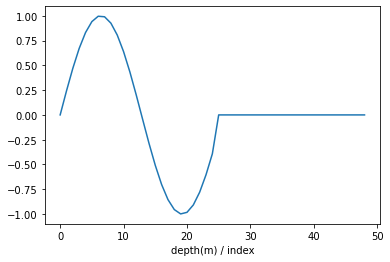

In [31]:
width_inv = 20
t = 1/ width_inv
duration = 0.098
dt = 0.002
time = np.linspace(0,duration, int(duration/dt))

# create your own zero-phase wavelet
zero_phase = np.sin( (width_inv)*6 * time)
zero_phase[np.where(time >= t)[0][0]:] = 0

plt.plot(zero_phase)
plt.xlabel('depth(m) / index')
plt.show()

**Question: write your own ricker function**

In [32]:
#def ricker(f, duration=0.098, dt=0.002):
#    t = np.linspace(-duration/2, (duration-dt)/2, int(duration/dt))
#    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
#    return t, y
#def Ricker(f0,t): # Ricker wavelet
#return (1-2*(pi*f0*t)**2)*np.exp(-(pi*f0*t)**2)

#f0=20. # Dominant frequency of Ricker wavelet (in Hz)
#t0=0.8 # Arrival time at zero offset (in s)


**QUESTION: Look into the references documentation ([see here](https://bruges.readthedocs.io/api/bruges.filters.wavelets.html)) and create an ormsby wavelet**

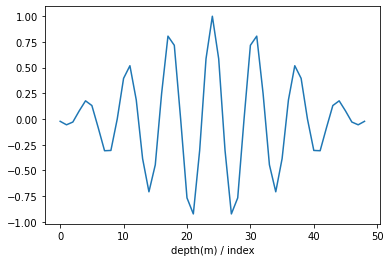

In [33]:
inv_width = [60, 70, 80, 90]
ormsby, t = bruges.filters.wavelets.ormsby(duration=0.098, dt=0.002, f=inv_width, return_t = True, sym=True)
plt.plot(ormsby)
plt.xlabel('depth(m) / index')
plt.show()

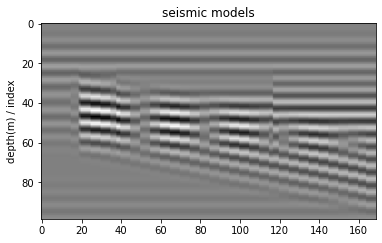

In [34]:
synth_ormsby = np.array([np.apply_along_axis(lambda t: np.convolve(t,ormsby, mode='same'), axis=0,
                             arr= reflection_coeff_1)])

plt.imshow(synth_ormsby[0], cmap='gray', aspect=1)
plt.title('seismic models')
plt.ylabel('depth(m) / index')
plt.show()


## Attenuation and noise
### 1. Spherical divergence

As seismic waves travel their amplitude decrease by 1/r, so the amplitude of reflections is actually lower than predicted in the example above which only considers amplitude changes related to reflection coefficient. One of the relatively early steps in seismic data processing is to remove this affect by doing the reverse of the calculation below. 

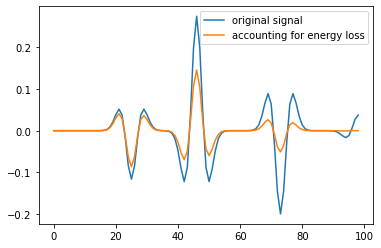

In [35]:
out = np.convolve(reflection_coeff_1[:,trace_1], ricker, mode='same') # take/create seismic trace
decay = np.linspace(1,0,len(out)) #linear decay, can vary this if we like
plt.plot(out, label='original signal')
plt.plot(out*decay, label='accounting for energy loss') # apply predicted/alculatecd decay to the trace
plt.legend()
plt.show()

### 2. Absorption, advanced/optional exercice

As seismic waves travel the high-frequency components which have shorter wavelengths are more readily absorbed and scattered. Therefore, as a seismic wave travels it's dominant frequency reduces. This affect is difficult to calculate as it will depend on the properties of the rock. In this example we are using a simple function to simulate frequency decrease with depth. 

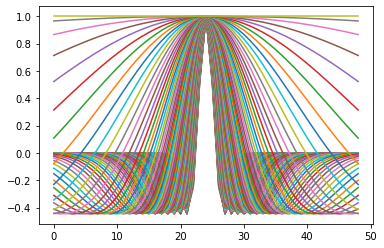

In [36]:
# reducing wavelengths as a function of depth
hz = 70
wave_decay = []
for z in np.linspace(1,0,int(np.shape(reflection_coeff_1)[0])):
    ws, t = bruges.filters.ricker(duration=0.098, dt=0.002, f=hz*z, return_t = True, sym = True);
    wave_decay.append(ws)
    plt.plot(ws)


**EXTENSION QUESTION: Now we want to convolve a wavelet that is a function of depth with our traces. Feel free to attempt this yourself first. One method of achieving this is writing our own convolution function.** 

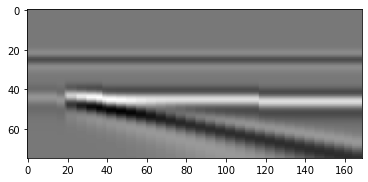

In [37]:
# accounting for frequency decay during convolution

# create zero padding above depth zero of half kernel size to maintain constant array output size
padding = np.zeros((np.shape(reflection_coeff_1)[0] + int(len(wave_decay[0])/2), np.shape(reflection_coeff_1)[1]))
padding[int(len(wave_decay[0])/2):, :] = reflection_coeff_1
synthetic = []

for trace in range(np.shape(reflection_coeff_1)[1]): #iterate over every trace
    convolved = [] # clean at each step
    for depth in range(np.shape(reflection_coeff_1)[0] - int(len(wave_decay[0])/2)): # iterate in depth direction across each trace
        inv_kernel = wave_decay[depth] # no need to inverse arr[::-1] as its symmetric
        convolved.append(np.sum(padding[depth: depth+len(inv_kernel), trace] * inv_kernel))
    synthetic.append(convolved)
    
#check size of output array
synthetic = np.array(synthetic)

plt.imshow(synthetic.T, cmap = 'gray')


### 3. Noise

In addition to the factors above incoherent noise ($N(z)$) will inevitably exist in seismic reflection images even after processing. Here we add incoherent noise to add realism to the seismic section. 

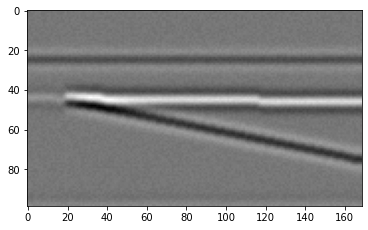

In [38]:
blurred = sp.ndimage.gaussian_filter(synth, sigma=1.1)
noisy = blurred + 0.5 * blurred.std() * np.random.random(blurred.shape)

#show
plt.imshow(noisy[0], cmap='gray', aspect=1)


This is still a very simplistic model, in the real world the function is much more complex when trying to extract the original Earth Model from the Data. For instance the convolution wavelet $W(z)$ consists of a variety of components itself, between many:
- source ghost
- receiver response
- intrument response
- receiver ghost

##  Challenge- imaging thin channels in an area of wind-turbine installation

You work for a contractor who are going to collect some seismic data in a region of wind-turbine installation. Preliminary assessments have involved drilling a series of boreholes to characterise the subsurface and from this a 2D geological model has been developed (channels.png). This model includes thin, low-velocity channels with a thickness of 5 m buried at a depth of 50 m. 

**Question: Using the relationships learned in the lecture what type of source will use to do this survey if we want to resolve the channels**

some lecture notes worth remembering:
- maximum vertical resolution is 1/4 of the dominant wavelength of the pulse (Rayleigh Criterion), $ \frac{1}{4} \lambda$
- absolute horizontal resolution -> smallest object that can be resolved wihtout migration-> $ width = \sqrt{\frac{ z * \lambda}{2}}    $

If we want to resolve 5 m in rocks with $V_p$ around 2500 m/s we need a wavelength of 20 m minimum, therefore $ f = \frac{v}{\lambda} = \frac{2500}{20} = 125 Hz$ . You could actually use airguns for this

**Question: Using everything you have learned in this section simulate a seismic section for which we can resolve both the top and base of the channels and identify when they start to disappear**

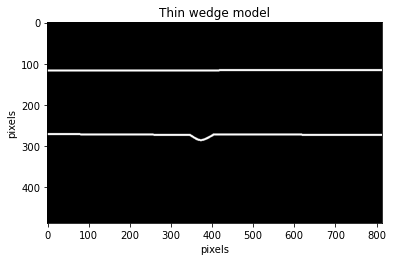

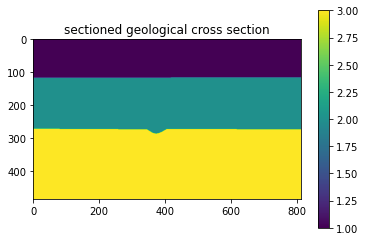

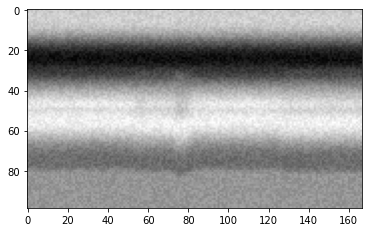

In [39]:
# user defined parameters
properties_ = np.array([[2700, 2750],  # p-wave velocity, denisty for layer 1
                  [2400, 2450],
                  [2600, 2650], 
                  [2500, 2550]])
hz = 10

# processing
img_ = seis.read_img('data/channel.png')
model_bound_ = label(img_) #identify each section
model_ = seis.remove_bounds(model_bound_)
model_ = sp.ndimage.zoom(model_, 1/(np.shape(model_)[0]/100), order=0)
earth_ = properties_[model_]
impedances_ = np.apply_along_axis(np.product, -1, earth_)
reflection_coeff_ = (impedances_[1:,:] - impedances_[:-1,:]) / (impedances_[1:,:] + impedances_[:-1,:])
ws = bruges.filters.ricker(duration=0.098, dt=0.002, f=hz, return_t = False);
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, ws, mode='same'), axis=0,
                             arr= reflection_coeff_)])
blurred = sp.ndimage.gaussian_filter(synth, sigma=1.1)
noisy = blurred + 0.5 * blurred.std() * np.random.random(blurred.shape)

#show
plt.imshow(noisy[0], cmap='gray', aspect=1)
plt.show()